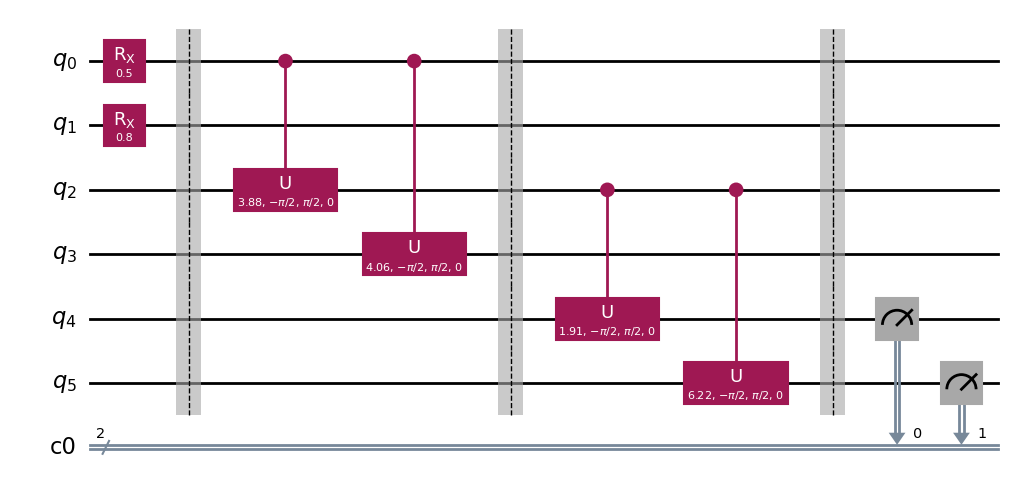

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.circuit import ParameterVector
import numpy as np

class QuantumFeedForwardNN:
    def __init__(self, n_qubits, n_layers, output_size, layer_size):
        """
        Initializes the Quantum Neural Network.
        
        Parameters:
        - n_qubits (int): Total number of qubits in the circuit.
        - n_layers (int): Number of layers in the network.
        - output_size (int): Number of qubits in the output layer.
        - layer_size (int): Number of qubits in each feed-forward layer.
        """
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.layer_size = layer_size
        self.output_size = output_size
        self.n_params = n_qubits - layer_size
        self.param_values = None
        self.params = None
        self.qc = None
    
    def _angle_encoding(self, qc, input_features):
        """
        Encodes input features onto the first `len(input_features)` qubits using Rx gates.
        """
        num_encoded_qubits = len(input_features)
        for i in range(num_encoded_qubits):
            qc.rx(input_features[i], i)
        qc.barrier()

    def _add_feed_forward_layer(self, qc):
        """
        Adds a feed-forward layer with parameterized gates that transfer information to the next layer.
    
        Parameters:
        - qc (QuantumCircuit): The circuit to which the layer is added.
        - layer_idx (int): Index of the current layer.
       """
        param_index = 0
        # Apply parameterized controlled gates from each qubit in the current layer to the next layer's qubits
        for i in range(0, self.n_qubits-layer_size, self.layer_size):
            control_qubits = list(range(i, layer_size+i-1))
            for j in range(layer_size):
                target_qubit = (i + layer_size + j) # Choose the next qubit as target
                qc.mcrx(self.params[param_index], control_qubits , target_qubit)
                param_index += 1
            qc.barrier()
    
    def _add_output_layer(self, qc):
        """
        Adds the output layer to the circuit.
        """
        qc.add_register(ClassicalRegister(self.output_size))
        for i in range(self.n_qubits - self.output_size, self.n_qubits):
            qc.measure(i, i - (self.n_qubits - self.output_size))

    def create_circuit(self, input_features): 
        """
        Creates the Quantum Neural Network circuit.
        """
        qc = QuantumCircuit(self.n_qubits)
        self.params = ParameterVector('θ', self.n_params)
        self._angle_encoding(qc, input_features)
        self._add_feed_forward_layer(qc) 
        self._add_output_layer(qc)
        self.qc = qc

    
# Example usage
n_qubits = 6
n_layers = 3 
output_size = 2
input_features = [0.5, 0.8]  # Example input features
layer_size = 2

qnn = QuantumFeedForwardNN(n_qubits, n_layers, output_size, layer_size)
qnn.create_circuit(input_features)
qnn.param_values = np.random.uniform(0, 2*np.pi, qnn.n_params)
qnn.qc.assign_parameters({qnn.params: qnn.param_values}, inplace=True)
qnn.qc.draw('mpl')  # Visualize the circuit
